In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rdflib
import numpy as np
from tqdm import tqdm

In [2]:
FIGURES_PREFIX = "meetups"
graph = rdflib.Graph().parse("resources/meetups.ttl")

In [10]:
artists = list(graph.query("""
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX core: <https://w3id.org/polifonia/ontology/core/>
PREFIX mm: <https://w3id.org/polifonia/ontology/music-meta/>
PREFIX mrs: <https://w3id.org/polifonia/ontology/relationship/>
PREFIX ponr: <https://w3id.org/polifonia/resource/>

SELECT DISTINCT ?s
WHERE {
  ?s ?rel ?t .
  FILTER (?s != ?t)
}
"""))

In [14]:
artists[0]

(rdflib.term.URIRef('http://dbpedia.org/resource/Joey_Baron'),)

In [12]:
inf_graph = rdflib.Graph().parse("resources/all_music.ttl")

In [16]:
inf_artists = list(inf_graph.query("""
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX core: <https://w3id.org/polifonia/ontology/core/>
PREFIX mm: <https://w3id.org/polifonia/ontology/music-meta/>
PREFIX mrs: <https://w3id.org/polifonia/ontology/relationship/>
PREFIX ponr: <https://w3id.org/polifonia/resource/>
prefix infpred: <https://w3id.org/influence/relation/>
prefix infres:  <https://w3id.org/influence/resource/>

SELECT DISTINCT ?sL
WHERE {
  ?s infpred:influencedBy ?t ;
     rdfs:label ?sL .
  FILTER (?s != ?t)
}
"""))

In [40]:
mm_artists_map = {" ".join(str(x[0]).split("/")[-1].split("_")).split(" (")[0]: str(x[0]) for x in artists}
mm_artists_str = list(mm_artists_map.keys())
inf_artists_str = [str(x[0]) for x in inf_artists]

In [25]:
import tfidf_matcher as tm

In [33]:
match = tm.matcher(inf_artists_str, mm_artists_str, k_matches=1, ngram_length=3)

In [41]:
match_map = {x["Original Name"]: mm_artists_map[x["Lookup 1"]] for _, x in match[match["Lookup 1 Confidence"] > 0.8].iterrows()}

In [55]:
list(graph.query("""
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX core: <https://w3id.org/polifonia/ontology/core/>
PREFIX mm: <https://w3id.org/polifonia/ontology/music-meta/>
PREFIX mrs: <https://w3id.org/polifonia/ontology/relationship/>
PREFIX ponr: <https://w3id.org/polifonia/resource/>

SELECT (COUNT(*) AS ?c)
WHERE {
  ?s mrs:admires ?t .
}
"""))

[(rdflib.term.Literal('12580', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')),)]

In [49]:
for s, _, t in inf_graph.triples((None, rdflib.URIRef("https://w3id.org/influence/relation/influencedBy"), None)):
  try:
    s_label = str(next(inf_graph.objects(subject=s, predicate=rdflib.RDFS.label)))
    t_label = str(next(inf_graph.objects(subject=t, predicate=rdflib.RDFS.label)))

    if s_label in match_map and t_label in match_map:
      s_aligned = rdflib.URIRef(match_map[s_label])
      t_aligned = rdflib.URIRef(match_map[t_label])
      graph.add((s_aligned, rdflib.URIRef("https://w3id.org/polifonia/ontology/relationship/admires"), t_aligned))
  except:
    pass

In [56]:
len(match)

3723

In [50]:
graph.serialize("resources/meetups_with_allmusic_influence.ttl")

<Graph identifier=N3d19e3b444274f7c802cbf1639c7cc8e (<class 'rdflib.graph.Graph'>)>

In [47]:
str(next(inf_graph.objects(subject=s, predicate=rdflib.RDFS.label)))

'Emmylou Harris'

## Plot stats

In [3]:
res = graph.query("""
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX core: <https://w3id.org/polifonia/ontology/core/>
PREFIX mm: <https://w3id.org/polifonia/ontology/music-meta/>
PREFIX mrs: <https://w3id.org/polifonia/ontology/relationship/>
PREFIX ponr: <https://w3id.org/polifonia/resource/>

SELECT ?rel (COUNT(?rel) AS ?c)
WHERE {
  ?s ?rel ?t .
  FILTER (?s != ?t)
}
GROUP BY ?rel
ORDER BY ?rel
""")

rel_map = {
  "hasBandmate": "Bandmate",
  "hasFellow": "Fellowship",
  "hasFriend": "Friendship",
  "hasAcquaintance": "Acquaintanceship",
}

relationships_data = {rel_map[str(rel).split("/")[-1]]: int(count) for rel, count in list(res)}

df = pd.DataFrame.from_dict(relationships_data, orient="index")
df

,0
Acquaintanceship,1074606
Bandmate,219828
Fellowship,666154
Friendship,246294


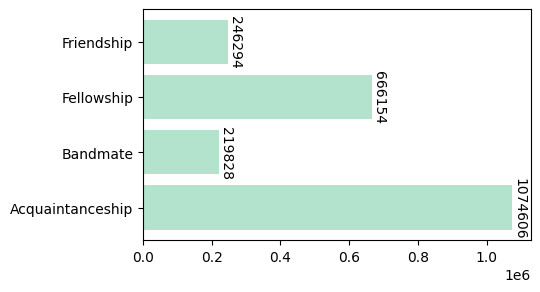

In [4]:
plt.figure(figsize=(5, 3))
bars = plt.barh(df.index, df.iloc[:, 0], color='#b3e2cd')


for bar in bars:
  plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', 
           va='center', ha='left', fontsize=10, rotation=270)

plt.savefig(f"figures/{FIGURES_PREFIX}_relations_distribution.png", bbox_inches="tight", dpi=300)

## Count how often two relationships co-occur

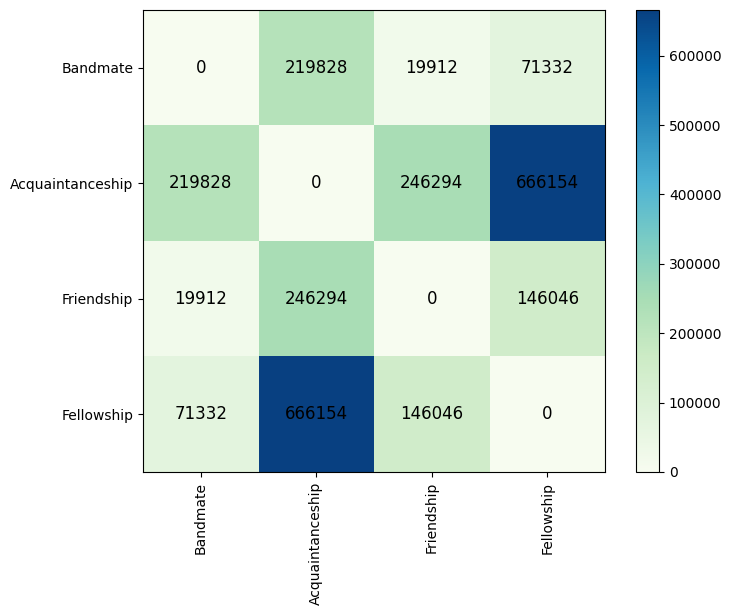

In [5]:
res = graph.query("""
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX core: <https://w3id.org/polifonia/ontology/core/>
PREFIX mm: <https://w3id.org/polifonia/ontology/music-meta/>
PREFIX mrs: <https://w3id.org/polifonia/ontology/relationship/>
PREFIX ponr: <https://w3id.org/polifonia/resource/>

SELECT ?rel_a ?rel_b (COUNT(*) AS ?c)
WHERE {
  ?s ?rel_a ?t .
  ?s ?rel_b ?t .
  FILTER (?s != ?t)
  FILTER (?rel_a != ?rel_b)
}
GROUP BY ?rel_a ?rel_b
ORDER BY DESC(?rel_a) ?rel_b
""")

co_occurrence_data = [
  (rel_map[str(rel_a).split("/")[-1]], rel_map[str(rel_b).split("/")[-1]], int(count))
   for rel_a, rel_b, count in list(res)]

names = list(set([x for x, _, _ in co_occurrence_data]))

co_occurrence = np.zeros((len(names), len(names)))

for x, y, v in co_occurrence_data:
  x_idx = names.index(x)
  y_idx = names.index(y)
  co_occurrence[x_idx, y_idx] = v

plt.figure(figsize=(8, 6))
heatmap = plt.imshow(co_occurrence, cmap="GnBu")

# Add value labels
for i in range(co_occurrence.shape[0]):
    for j in range(co_occurrence.shape[1]):
        plt.text(j, i, int(co_occurrence[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.colorbar(heatmap)
plt.xticks(ticks=np.arange(len(names)), labels=names, rotation=90)
plt.yticks(ticks=np.arange(len(names)), labels=names)

plt.savefig(f"figures/{FIGURES_PREFIX}_co_occurrence.png", bbox_inches="tight", dpi=300)

## A simple baseline

In [6]:
# graph = rdflib.Graph().parse("resources/linked_jazz.nt")

# artists = [x for x, _, _ in graph.triples((None, rdflib.RDF.type, rdflib.URIRef("https://w3id.org/polifonia/ontology/music-meta/MusicArtist")))]
# relationship_types = ['Mentorship', 'Bandmate', 'Acquaintanceship', 'Friendship', 'Admiration']

# data_matrix = np.zeros((len(artists), len(artists), len(relationship_types)))

# for artist_idx, artist in tqdm(list(enumerate(artists))):
#   res = graph.query("""
#   PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
#   PREFIX mrs: <https://w3id.org/polifonia/ontology/relationship/>
#   SELECT ?t ?rel
#   WHERE {
#     [] mrs:hasSource <%s> ;
#       mrs:hasTarget ?t ;
#       dul:isClassifiedBy ?rel .
#   }""" % str(artist))
  
#   for other, rel in res:  
#     other_idx = artists.index(other)
#     r_idx = relationship_types.index(str(rel).split("/")[-1])
#     data_matrix[artist_idx, other_idx, r_idx] = 1

In [7]:
# from sklearn.model_selection import train_test_split, cross_validate
# from sklearn.metrics import recall_score
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import MultinomialNB, GaussianNB
# from sklearn.linear_model import LinearRegression
# from sklearn.neural_network import MLPClassifier

# X = data_matrix[:, :, :-1].reshape(-1, 4)
# y = data_matrix[:, :, -1].reshape(-1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [8]:
# clfs = [DecisionTreeClassifier(), GaussianNB(), LinearSVC()]
# for clf in clfs:
#   pred = clf.fit(X_train, y_train).predict(X_test)
#   print(clf, recall_score(pred, y_test))